# Классификация

## Utility code


In [1]:
from sklearn.datasets import make_classification
import numpy as np

def fetch_dataset():
    return make_classification(n_samples=1000, n_features=10,
                               n_informative=5, n_classes=2,
                               weights=[0.92, 0.08], flip_y=0.02,
                               random_state=13)

class BlackBoxMethod:
    def __init__(self, label=0):
        self.label = label
    def fit(self, X, y):
        return self
    def predict(self, X):
        n = X.shape[0]
        if self.label == 1:
            return np.ones(n, dtype=int)
        else:
            return np.zeros(n, dtype=int)
    def predict_proba(self, X):
        n = X.shape[0]
        np.random.seed(13)
        if self.label == 1:
            return np.random.uniform(0.51, 0.99, size=n)
        else:
            return np.random.uniform(0.01, 0.49, size=n)

## Импортируем необходимые библиотеки

In [2]:
import numpy as np
import pandas as pd
# from clf_utils import BlackBoxMethod, fetch_dataset # если есть доступ к файлу, раскомментить
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, auc,
                             classification_report)
from sklearn.model_selection import train_test_split

Воспользуемся заранее подготовленным файлом clf_utils, с его помощью сгенерируем датасет и инициализируем некоторую модель (что за модель, узнаем дальше)

In [3]:
X, y = fetch_dataset()
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=13)

In [4]:
model = BlackBoxMethod()

In [5]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.912


Получили вполне хорошую точность, но можно ли считать задачу выполненной? Давайте посмотрим на предсказания модели

(array([  0.,   0.,   0.,   0.,   0., 250.,   0.,   0.,   0.,   0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

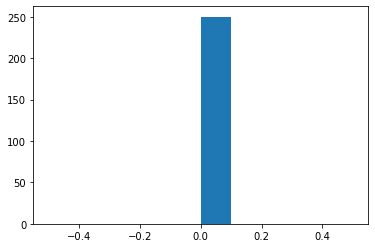

In [6]:
plt.hist(y_pred)

На самом деле модель всегда предсказывает лишь одно значение - ноль. Но почему же тогда получили хорошую точность?

Давайте посмотрим на распределение меток в нашем датасете

<AxesSubplot:title={'center':'Count (target)'}>

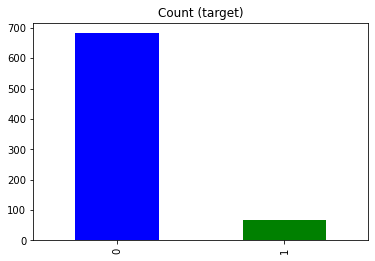

In [7]:
df = pd.DataFrame(X_train)
df['target'] = y_train
df.target.value_counts().plot(kind='bar', title='Count (target)', color = ['b', 'g'])

Можем заметить, что имеется сильная несбалансированность классов. Давайте рассмотрим шаги, которые помогут нам работать с такими датасетами

1. Использовать другие метрики. Как видим, метрика точность не является хорошим вариантом для задачи с сильно несбалансированными классами
2. Использовать другой алгоритм, а не тот, что всегда предсказывает 0)
3. Использовать методы для улучшения качества предсказания на несбалансированном датасете

Пойдем по порядку

## 1. Другие метрики

Для начала введем обозначения:
||Actual Positive|Actual Negative|
|--|--|--|
|Predicted Positive|True Positive (TP)|False Positive (FP)|
|Predicted Negative|False Negative (FN)|True Negative (TN)|

На основании введенных обозначений напишем формулы, по которым считаются метрики precision и recall
$$
    precision = \frac{TP}{TP + FP}
$$

$$
    recall = \frac{TP}{TP + FN}
$$


Простыми словами precision - это то, какой процент меток, которые наш алгоритм признал положительными, на самом деле являются положительными; recall - это какой процент положительных меток наш алгоритм смог найти из всех положительных меток. Возможно, станет понятнее на картинке

<img src="https://miro.medium.com/max/1400/1*r-7EeiYXYS_vjKhZV_ukyg.png" width=1000/>

Также есть метрика, которая объединяет в себе precision и recall, f1-score. Она является средним гармоническим между precision и recall
$$
 F_1 = 2 \frac{precision \cdot recall}{precision + recall}
$$

Есть и общий случай этой метрики, $F_{\beta}$-score, в которой с помощью параметра $\beta$ можно контролировать, чему при усреднении придать больший вес, precision ($\beta < 1$) или recall ($\beta > 1$):

$$
F_{\beta} = (1 + \beta^2) \frac{precision \cdot recall}{(\beta^2 \cdot precision) + recall}
$$

Кроме того, часто используется ROC-кривая (Reciever Operating Characteristic). Это кривая в осях FPR (false positive rate), TPR (true positive rate). Для получения кривой пробегаются все возможные значения порога, с помощью которого происходит разделение на положительные и отрицательные метки, и затем полученные точки наносятся на график

$$
    FPR = \frac{FP}{FP + TN}
$$

$$
    TPR = \frac{TP}{TP + FN}
$$

<img src="https://upload.wikimedia.org/wikipedia/commons/1/13/Roc_curve.svg" width=400 height=400 />

Чтобы привести эту метрику к числу, считают площадь под ROC-кривой. Эта метрика называется ROC-AUC

Рассчитаем метрики для предыдущего метода

In [8]:
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))

Precision: 0.0
Recall: 0.0
F1 score: 0.0


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


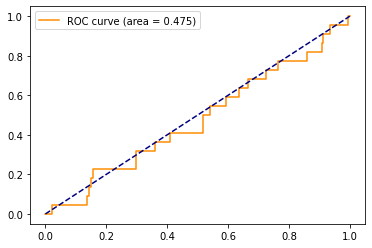

In [9]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test))
plt.plot(fpr, tpr, color="darkorange", label=f"ROC curve (area = {auc(fpr, tpr):0.3f})")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.legend()

## 2. Другие алогоритмы

Попробуем применить другие алгоритмы и посмотреть на результаты

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import RocCurveDisplay

def try_model(model, X_train, y_train, X_test, y_test, model_params=None):
    if model_params is None:
        model_params = dict()
    print(model.__name__)
    pipeline = make_pipeline(StandardScaler(), model(**model_params))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred))
    print('Recall:', recall_score(y_test, y_pred))
    print('F1 score:', f1_score(y_test, y_pred))

    fpr, tpr, thresholds = roc_curve(y_test, pipeline.predict_proba(X_test)[:, 1])
    plt.plot(fpr, tpr, color="darkorange", label=f"ROC curve (area = {auc(fpr, tpr):0.3f})")
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.legend()

    # for sklearn.__version__ of 1.0 and above
    # display = RocCurveDisplay.from_estimator(pipeline, X_test, y_test)
    # display.plot()
    # plt.show()
    return pipeline

LogisticRegression
Accuracy: 0.908
Precision: 0.0
Recall: 0.0
F1 score: 0.0


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

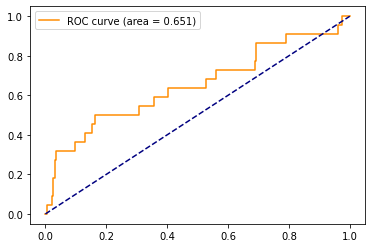

In [11]:
try_model(LogisticRegression, X_train, y_train, X_test, y_test)

GaussianNB
Accuracy: 0.884
Precision: 0.1111111111111111
Recall: 0.045454545454545456
F1 score: 0.06451612903225805


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gaussiannb', GaussianNB())])

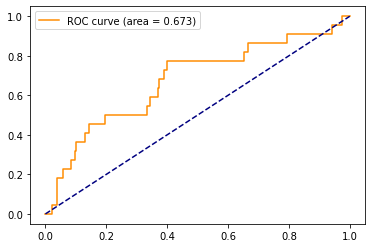

In [12]:
try_model(GaussianNB, X_train, y_train, X_test, y_test)

KNeighborsClassifier
Accuracy: 0.928
Precision: 0.8333333333333334
Recall: 0.22727272727272727
F1 score: 0.35714285714285715


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

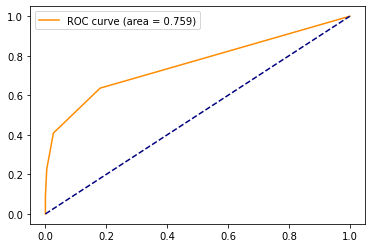

In [13]:
try_model(KNeighborsClassifier, X_train, y_train, X_test, y_test)

SVC
Accuracy: 0.912
Precision: 0.0
Recall: 0.0
F1 score: 0.0


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(kernel='linear', probability=True))])

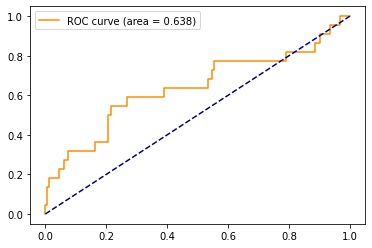

In [14]:
try_model(SVC, X_train, y_train, X_test, y_test,
          model_params=dict(
            kernel='linear',
            probability=True,
))

## 3. Работа с несбалансированным датасетом

Для решения проблемы несбалансированного датасета можно воспользоваться некоторыми способами. Некоторые из них:
- Down-sampling - Уменьшение количества примеров большего класса с помощью выбрасивания части примеров (учитывая репрезентативность выборки)
- Synthetic minority over-sampling technique (SMOTE) - Метод одновременного Up-sampling и Down-sampling. Для Up-sampling метод берет случайную точку меньшего класса, находит k ближайших соседей и выводит некоторое усреднение этих точек
- Threshold - можно уменьшить (или увеличить) threshold от стандартных 0.5
- Также можно давать объектам из меньшего класса больший вес в функции потерь, что заставит алгоритм обратить большее внимание на эти точки

Для использования части из предложенных решений удобно использовать библиотеку imbalanced-learn

Ниже вы можете выбрать команду для установки этой библиотеки (через Anaconda или через pip)

In [15]:
# ! pip install -U imbalanced-learn
# ! conda install -c conda-forge imbalanced-learn

In [16]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler

### Down-sampling

In [17]:
X_rus, y_rus = RandomUnderSampler().fit_sample(X_train, y_train)

<AxesSubplot:title={'center':'Count (target)'}>

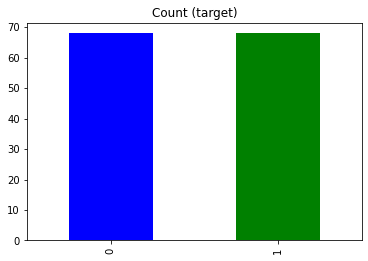

In [18]:
df = pd.DataFrame(X_rus)
df['target'] = y_rus
df.target.value_counts().plot(kind='bar', title='Count (target)', color = ['b', 'g'])

LogisticRegression
Accuracy: 0.6
Precision: 0.14545454545454545
Recall: 0.7272727272727273
F1 score: 0.2424242424242424


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

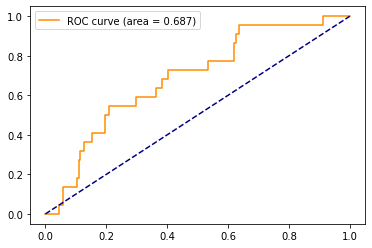

In [19]:
try_model(LogisticRegression, X_rus, y_rus, X_test, y_test)

### SMOTE

LogisticRegression
Accuracy: 0.632
Precision: 0.11956521739130435
Recall: 0.5
F1 score: 0.1929824561403509


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

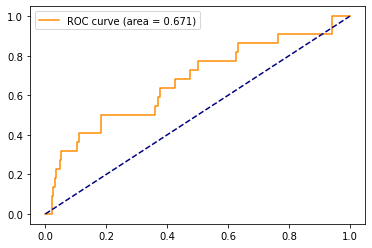

In [20]:
X_sm, y_sm = SMOTE().fit_sample(X_train, y_train)
try_model(LogisticRegression, X_sm, y_sm, X_test, y_test)

### Задание каждому классу своего веса

Это можно сделать с помощью параметра class_weight (значение 'balanced' выставит веса, обратно пропорциональные частоте классов)

LogisticRegression
Accuracy: 0.628
Precision: 0.12631578947368421
Recall: 0.5454545454545454
F1 score: 0.20512820512820515


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced'))])

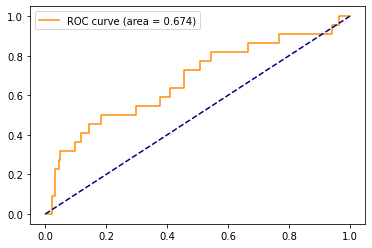

In [21]:
try_model(LogisticRegression, X_train, y_train, X_test, y_test,
          model_params=dict(
            class_weight='balanced',
))

## Многоклассовая классификация

Воспользуемся датасетом с ирисами, включенном в sklearn

In [32]:
from sklearn.datasets import load_iris

In [33]:
data = load_iris()
X, y = data['data'], data['target']

Посмотрим на распределение по классам

<AxesSubplot:title={'center':'Count (target)'}>

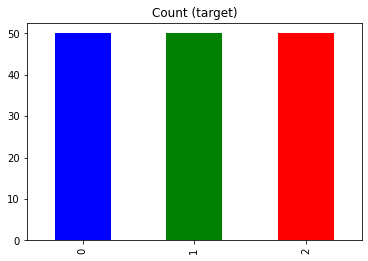

In [34]:
df = pd.DataFrame(X)
df['target'] = y
df.target.value_counts().plot(kind='bar', title='Count (target)', color = ['b', 'g', 'r'])

Разделим на train/test

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=13)

Прежде разберемся как оценивать качество моделей в мультиклассовой классификации

### Метрики для мультиклассовой классификации

Попробуем перенести метрики, которые мы обсуждали выше, на многоклассовый случай. Сначала для каждого класса y посчитаем следующие значения:

||Actual y|Actual not y|
|--|--|--|
|Predicted y|True Positive ($TP_y$)|False Positive ($FP_y$)|
|Predicted not y|False Negative ($FN_y$)|True Negative ($TN_y$)|

Далее на примере метрик precision и recall покажем 2 вида усреднения

#### Micro averaging

$$
precision = \frac{\sum_y TP_y}{\sum_y (TP_y + FP_y)}
$$


$$
recall = \frac{\sum_y TP_y}{\sum_y (TP_y + FN_y)}
$$

#### Macro averaging

$$
precision = \frac{1}{|Y|} \sum_y \frac{TP_y}{TP_y + FP_y}
$$

$$
recall = \frac{1}{|Y|} \sum_y \frac{TP_y}{TP_y + FN_y}
$$

Все другие метрики вычисляются аналогично. Выбор конкретного типа усреднения зависит от требований задачи

### Стратегии для многоклассовой классификации

Есть алгоритмы, которые нативно могут работать с многоклассовым случаем (например, деревья или наивный Байес). Однако модели наподобие логистической регрессии или SVM изначально рассматривают бинарную классификацию. Далее на примере этих алгоритмов рассмотрим стратегии для работы с мультиклассом

#### One vs Rest (OVR)

В случае one vs rest для M классов строим M моделей. Для каждой модели разделяем некоторый класс y (ставим ему метку 1) и все остальные классы (ставим любому другому классу метку 0). То есть фактически разделяем класс y против всех остальных. Для предсказания прогоняем вектор признаков через все модели и затем выбираем тот класс, для которого вероятность принадлежности к классу y была выше. Минусом данного подхода является несбалансированность классов внутри каждой из M моделей

Рассмотрим, как можно реализовать One vs Rest на примере SVM

In [38]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

pipe = make_pipeline(
    StandardScaler(),
    OneVsRestClassifier(LinearSVC())
)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print("F1-score (macro):", f1_score(y_test, y_pred, average='macro'))
print("F1-score (micro):", f1_score(y_test, y_pred, average='micro'))

Accuracy: 1.0
F1-score (macro): 1.0
F1-score (micro): 1.0


У некоторых алгоритмов есть встроенная поддержка стратегий для многоклассовой классификации. Например, это есть и в SVM (смотрите документацию)

In [39]:
pipe = make_pipeline(
    StandardScaler(),
    LinearSVC(multi_class='ovr')
)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print("F1-score (macro):", f1_score(y_test, y_pred, average='macro'))
print("F1-score (micro):", f1_score(y_test, y_pred, average='micro'))

Accuracy: 1.0
F1-score (macro): 1.0
F1-score (micro): 1.0


#### One vs One (OVO)

В этом подходе стоим $C_M^2$ моделей, которые попарно разделяют каждый класс с каждым. Для предсказания выбирается класс, за который больше всего "голосов". В этом подходе проблема в том, что число моделей растет квадратично с числом классов

In [40]:
from sklearn.multiclass import OneVsOneClassifier

pipe = make_pipeline(
    StandardScaler(),
    OneVsOneClassifier(LinearSVC())
)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print("F1-score (macro):", f1_score(y_test, y_pred, average='macro'))
print("F1-score (micro):", f1_score(y_test, y_pred, average='micro'))

Accuracy: 0.9736842105263158
F1-score (macro): 0.9731615673644659
F1-score (micro): 0.9736842105263158


#### Multinomial в логистической регрессии

Кратко вспомним, как устроена логистическая регрессия для случая бинарной классификации. Мы делаем линейное преобразование входных признаков и получаем число (логит), к которому потом применяем сигмоиду и обучаемся, стараясь минимизировать функцию потерь - бинарную кросс-энтропию. В случае M классов есть идея после линейного преобразования получать не одно число, а M чисел, к которым далее применять преобразования. Что же это за преобразование? Называется оно softmax:

$$
    softmax(z) = \frac{exp(z_i)}{\sum\limits_{i=1}^M exp(z_i)}
$$

После применения функции softmax, получим вероятности принадлежности к классу. Обучаем модель, минимизируя кросс-энтропию


In [41]:
pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression(multi_class='multinomial')
)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print("F1-score (macro):", f1_score(y_test, y_pred, average='macro'))
print("F1-score (micro):", f1_score(y_test, y_pred, average='micro'))

Accuracy: 1.0
F1-score (macro): 1.0
F1-score (micro): 1.0
